<a href="https://colab.research.google.com/github/mmsamiei/MS-Thesis-Phase2/blob/master/Models/Bakeri/Bakeri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [2]:
!nvidia-smi

Wed May 13 22:54:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/My\ Drive/Thesis/phase-2/history_sentence_pairs_train.csv ./train.csv
!cp /content/drive/My\ Drive/Thesis/phase-2/history_sentence_pairs_valid.csv ./valid.csv

In [0]:
!pip -q install transformers

In [0]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-4_H-128_A-2')

In [0]:
import random
import pandas as pd
import logging

class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, frac=1, split_rate=1, bound=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.dialogues = pd.read_csv(csv_file)
        self.dialogues.dropna(inplace=True)
        if bound:
          self.dialogues = self.dialogues[(self.dialogues['history'].apply(len)<280) 
          & (self.dialogues['false_sentence'].apply(len)<280) 
          & (self.dialogues['true_sentence'].apply(len)<280)]
        
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        self.dialogues = self.dialogues.sample(frac=frac)
        
        # s = (self.dialogues.true_sentence.str.len() + self.dialogues.history.str.len()).sort_values().index
        # self.dialogues = self.dialogues.reindex(s)
        # s = (self.dialogues.false_sentence.str.len() + self.dialogues.history.str.len()).sort_values().index
        # self.dialogues = self.dialogues.reindex(s)


        self.dialogues.dropna(inplace=True)


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=510):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove)
            seq_1.reverse()
        result_list = [tokenizer.cls_token_id]+seq_1+[tokenizer.sep_token_id]+seq_2+[tokenizer.sep_token_id]
        return result_list


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        true_sentence = self.dialogues.iloc[idx].true_sentence
        false_sentence = self.dialogues.iloc[idx].false_sentence


        true_pair = MyDataset.truncuate_join_pair_sentence(history, true_sentence)
        false_pair = MyDataset.truncuate_join_pair_sentence(history, false_sentence)
        
        

        true_pair = torch.LongTensor(true_pair)
        false_pair = torch.LongTensor(false_pair)

        sample = {'true_pair': true_pair, 'false_pair': false_pair}

        return sample

In [6]:
train_dataset = MyDataset('train.csv', split_rate=1, bound=True)
valid_dataset = MyDataset('valid.csv', split_rate=3)
print(len(train_dataset))
print(len(valid_dataset))

1178289
49143


In [7]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_true_pair = max([len(data['true_pair']) for data in batch])
  max_len_false_pair = max([len(data['false_pair']) for data in batch])
  
  padding_ind = 0 ## for bert is 0
  result_true_pair = torch.zeros(len_batch, max_len_true_pair)
  result_false_pair = torch.zeros(len_batch, max_len_false_pair)

  for i, data in enumerate(batch):
    p1 = len(data['true_pair'])
    result_true_pair[i, :p1] = data['true_pair']
    p2 = len(data['false_pair'])
    result_false_pair[i, :p2] = data['false_pair']


  return result_true_pair.long(), result_false_pair.long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                             shuffle=True, collate_fn=my_collate_fn,
                                           num_workers=1)

valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, sampler=valid_sampler,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)

i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  true_batch, false_batch = batch
  print(false_batch.shape)
  i += 1 
  if(i==4):
    break

torch.Size([32, 101])
torch.Size([32, 110])
torch.Size([32, 104])
torch.Size([32, 88])


In [9]:
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.bert = AutoModel.from_pretrained("google/bert_uncased_L-4_H-128_A-2")
    self.fc = nn.Linear(128,1)
    self.activation = nn.Tanh()

    for p in self.bert.embeddings.parameters():
      p.requires_grad = False
    
    nn.init.xavier_normal_(self.fc.weight)
  
  def forward(self, x):
        temp = x
        temp = self.bert(temp)[0]
        ## temp = [batch, len, hid_size]
        temp = temp[:,0,:]
        temp = self.fc(temp)
        temp = self.activation(temp)
        temp = (temp - (-1))/2 
        return temp

dev = torch.device('cuda')
model = Model().to(dev)


# x = torch.LongTensor(200, 40).random_(1,1000).to(dev)
# print(model(x).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

809729


In [0]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self):
        self.optimizer.zero_grad()

In [0]:
optimizer = NoamOpt(128, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

#optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

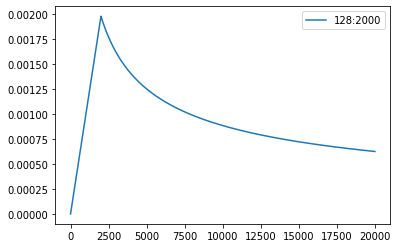

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1, 20000), [optimizer.rate(i) for i in range(1, 20000)])
plt.legend(["128:2000", "512:8000", "256:4000"])

In [0]:
import torch.nn.functional as F

def mahdi_loss(true_sml, false_sml):
  eps = 1e-8
  loss = torch.mean( -torch.log(true_sml+eps)-torch.log(1-false_sml+eps))
  return loss

In [0]:
from tqdm.auto import tqdm

def train_step(batch_idx, batch):
  true_pairs, false_pairs = batch
  true_pairs = true_pairs.to(dev)
  false_pairs = false_pairs.to(dev)
  optimizer.zero_grad()
  true_sml = model(true_pairs)
  false_sml = model(false_pairs)
  loss = mahdi_loss(true_sml, false_sml)
  loss.backward()
  optimizer.step()
  del true_pairs
  del false_pairs
  return loss.item()

def valid_step(batch_idx, batch):
  true_pairs, false_pairs = batch
  true_pairs = true_pairs.to(dev)
  false_pairs = false_pairs.to(dev)
  true_sml = model(true_pairs)
  false_sml = model(false_pairs)
  z = true_sml - false_sml
  num_err = z[z<0].size()[0]
  return num_err

def valid_loop(valid_loader):
  total_error = 0
  model.eval()
  for batch_idx, batch in tqdm(enumerate(valid_loader),  total=len(valid_loader)):
    total_error += valid_step(batch_idx, batch)
  return total_error / len(valid_dataset)

In [0]:
new_learning = True
if new_learning:
  model_dir = "/content/drive/My Drive/Thesis/phase-2/Models/bakeri/"
  step = 0
  log_list = []

In [17]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Thesis/phase-2/Models/bakeri/"
checkpoint = torch.load(model_dir+'bakeri_38000steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
log_list = checkpoint['log_list']
new_learning = False
print(step)

38000


In [18]:
optimizer._step

38000

In [0]:
from tqdm.auto import tqdm

MAX_STEP = 200000
STEP_SAVE = 2000 
STEP_CHECK = 20000
step_num = step + 1
log_list = log_list ### Check if new learning or not
print(step_num)
while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in tqdm(enumerate(iter(train_loader)), total=len(train_loader)):
    step_loss = train_step(batch_idx, batch)
    log = {'step':step_num, 'train_loss':step_loss}

    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      print("Error rate: {} at step {}".format(valid_error, step_num))  
      log['valid_error'] = valid_error
      log_list.append(log)
      model.train()
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.optimizer.state_dict() 
            }, model_dir+'bakeri_{}steps.model'.format(step_num))
      step_num += 1
      continue
    
    log_list.append(log)
    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.optimizer.state_dict()
            }, model_dir+'bakeri_{}steps.model'.format(step_num))
    step_num += 1



Error rate: 0.44368475673035834 at step 20000

Error rate: 0.44368475673035834 at step 20000


In [0]:
checkpoint = torch.load(model_dir+'bagheri_50000steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.eval()

In [0]:
checkpoint['log_list'][-100:]

[{'step': 49901, 'train_loss': 0.8324142694473267},
 {'step': 49902, 'train_loss': 0.920741081237793},
 {'step': 49903, 'train_loss': 0.8677593469619751},
 {'step': 49904, 'train_loss': 0.8985825777053833},
 {'step': 49905, 'train_loss': 0.8031026124954224},
 {'step': 49906, 'train_loss': 0.9139066338539124},
 {'step': 49907, 'train_loss': 0.9318299293518066},
 {'step': 49908, 'train_loss': 0.683719277381897},
 {'step': 49909, 'train_loss': 0.8610292673110962},
 {'step': 49910, 'train_loss': 0.8241980075836182},
 {'step': 49911, 'train_loss': 0.798753559589386},
 {'step': 49912, 'train_loss': 0.8694151639938354},
 {'step': 49913, 'train_loss': 0.790998101234436},
 {'step': 49914, 'train_loss': 0.7303371429443359},
 {'step': 49915, 'train_loss': 0.9581151604652405},
 {'step': 49916, 'train_loss': 0.8623735904693604},
 {'step': 49917, 'train_loss': 0.7973780632019043},
 {'step': 49918, 'train_loss': 0.807317852973938},
 {'step': 49919, 'train_loss': 0.8690530061721802},
 {'step': 49920, 

In [0]:
test_df = pd.read_csv('/content/drive/My Drive/Thesis/phase-2/history_sentence_pairs_test_unseen.csv')
test_df.fillna(' ', inplace=True)
mrr_df = pd.DataFrame(data=test_df.history.unique(), columns=['history'])
mrr_df['correct_rank'] = 0

In [0]:
test_df_gb = test_df.groupby(['history','true_sentence'])
for case in tqdm(test_df_gb):
  history = case[0][0]
  true_sentence = case[0][1]
  true_pair = torch.LongTensor(MyDataset.truncuate_join_pair_sentence(history, true_sentence)).reshape(1, -1).to(dev)
  true_sml = model(true_pair)
  case_df = case[1]
  for false_sentence in case_df['false_sentence']:
    false_pair = torch.LongTensor(MyDataset.truncuate_join_pair_sentence(history, false_sentence)).reshape(1, -1).to(dev)
    false_sml = model(false_pair)
    if(true_sml.item() < false_sml.item()):
      mrr_df.loc[mrr_df['history']==history, 'correct_rank'] += 1

In [0]:
len(mrr_df[ mrr_df['correct_rank'] < 5 ]) / len(mrr_df)

0.5211018448319434